In [1]:
# !pip install aplpy
# !pip install astroquery

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import shutil
import time
import copy
from scipy.ndimage import median_filter

import torch
import torchvision
from torch.nn import functional as F
from PIL import Image, ImageDraw, ImageFont

import aplpy
import astropy.io.fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization.wcsaxes import add_scalebar
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

import warnings

In [3]:
import sys
sys.path.append('/home/elmegreen/galactic_bubble/photoutils/')
from processing import remove_nan
from utils.ssd_model import nm_suppression

In [4]:
def conv(obj_size, obj_sig, data):
    """
    Input size of data↓
    Input: (y, x, 2 or 3)
    Output: (size, size, 2 or 3)
    -------------------------------
    If the cut-out data is larger than obj_size, perform smoothing.
    If it's smaller, return it as is.
    """
    if data.shape[0] > obj_size*1.1:
        fwhm = (data.shape[0] / obj_size) * 2
        sig3 = fwhm / (2 * (2 * np.log(2)) ** (1 / 2))
        if sig3 > obj_sig:
            sig2 = (sig3**2 - obj_sig**2) ** (1 / 2)        
            kernel = np.outer(signal.gaussian(8 * round(sig2) + 1, sig2), signal.gaussian(8 * round(sig2) + 1, sig2))
            kernel1 = kernel / np.sum(kernel)
    
            # conv_list = []
            # for k in range(data.shape[2]):
            #     cut_data_k = data[:, :, k]
            #     lurred_k = signal.fftconvolve(cut_data_k, kernel1, mode="same")
            #     conv_list.append(lurred_k[:, :, None])
    
            pi = signal.fftconvolve(data, kernel1, mode="same")
        else:
            pi = data
    else:
        pi = data
    return pi
# 
sig1_g = (0.269/0.11)/(2*(2*np.log(2))**(1/2))
sig1_r = (0.674/0.11)/(2*(2*np.log(2))**(1/2))

In [5]:
def load_detection_results(result_path, sizes, threshold):
    """
    保存された検出結果(.npy)を読み込み、信頼度でフィルタリングする
    """
    all_bboxes, all_scores = [], []
    
    print("検出結果を読み込んでいます...")
    for size in sizes:
        try:
            detections = np.load(os.path.join(result_path, f'result_ring_select_csize{size}.npy'))
            positions = np.load(os.path.join(result_path, f'position_ring_select_csize{size}.npy'))
        except FileNotFoundError:
            print(f"警告: csize={size} の結果ファイルが見つかりません。スキップします。")
            continue
            
        for detection_data, pos_data in zip(detections, positions):
            # ringクラス[1]の信頼度[0]が閾値以上のものを抽出
            ring_detections = detection_data[1] 
            confident_indices = np.where(ring_detections[:, 0] >= threshold)[0]
            
            if len(confident_indices) == 0:
                continue

            for index in confident_indices:
                score = ring_detections[index, 0]
                bbox = ring_detections[index, 1:] 
                # if np.any(bbox >= 1) or np.any(bbox <= 0):
                #     pass
                # else:
                bbox *= [size, size, size, size]
                # 全体座標に変換
                bbox += np.array([pos_data[1], pos_data[0], pos_data[1], pos_data[0]])
                
                all_bboxes.append(bbox)
                all_scores.append(score)
                
    return np.array(all_bboxes), np.array(all_scores)

In [6]:
def fit_lognormal_component(data):
    """
    データから対数正規成分をフィッティングして統計値を取得
    """
    # NaNを除去し、正の値のみを使用
    clean_data = data[~np.isnan(data) & (data > 0)]
    
    if len(clean_data) < 10:  # データが少なすぎる場合
        warnings.warn("データが少なすぎるため、通常の統計値を使用します")
        return np.nanmean(data), np.nanstd(data)
    
    try:
        # 対数正規分布のパラメータをフィッティング
        # lognormのパラメータ: s(shape), loc(location), scale
        params = lognorm.fit(clean_data, floc=0)  # locationを0に固定
        s, loc, scale = params
        
        # 対数正規分布の統計値を計算
        lognorm_mean = lognorm.mean(s, loc=loc, scale=scale)
        lognorm_std = lognorm.std(s, loc=loc, scale=scale)
        
        return lognorm_mean, lognorm_std
        
    except Exception as e:
        warnings.warn(f"対数正規分布のフィッティングに失敗: {e}. 通常の統計値を使用します")
        return np.nanmean(clean_data), np.nanstd(clean_data)

def norm_rp_improved(data, nan_data_dim=None, use_lognormal=True, min_method='std'):
    """
    改良された正規化関数
    
    Parameters:
    -----------
    data : numpy.ndarray
        正規化するデータ
    nan_data_dim : numpy.ndarray, optional
        統計値計算用の参照データ（Noneの場合はdataを使用）
    use_lognormal : bool, default=True
        対数正規分布を使用するかどうか
    min_method : str, default='std'
        最小値の決定方法 ('min', 'std', '2std')
    
    Returns:
    --------
    numpy.ndarray
        正規化されたデータ
    """
    # 参照データの決定
    ref_data = nan_data_dim if nan_data_dim is not None else data
    
    if use_lognormal:
        # 対数正規成分から統計値を取得
        mean, std = fit_lognormal_component(ref_data)
    else:
        # 従来の方法（ガウス分布仮定）
        mean = np.nanmean(ref_data)
        std = np.nanstd(ref_data)
    
    # 最大値の計算（3σルール）
    max_val = mean + 3 * std
    
    # 最小値の決定
    if min_method == 'min':
        min_val = np.nanmin(ref_data)
    elif min_method == 'std':
        min_val = mean - std
    elif min_method == '2std':
        min_val = mean - 2 * std
    else:
        raise ValueError("min_method must be 'min', 'std', or '2std'")
    
    # 最大値が小さすぎる場合の対処
    if max_val < 0.5:
        max_val = 0.5
    
    # 最小値がデータの最小値より大きくなりすぎないように調整
    data_min = np.nanmin(ref_data)
    if min_val > data_min + (max_val - data_min) * 0.5:
        min_val = data_min
    
    # 正規化の実行
    data_normalized = data.copy()
    data_normalized -= min_val
    data_normalized /= (max_val - min_val)
    
    return data_normalized

In [7]:
def norm_rp(data, nan_data_dim=None):
    if nan_data_dim is not None:
        data_min = np.nanmin(nan_data_dim)
        std = np.nanstd(nan_data_dim)
        mean = np.nanmean(nan_data_dim)
        max_ = mean + 3 * std
    else:
        data_min = np.nanmin(data)
        std = np.nanstd(data)
        mean = np.nanmean(data)
        max_ = mean + 3 * std

    if max_ < 0.5:
        max_ = 0.5
    data -= data_min
    data /= max_
    return data


def normalize_rp(array, r_header, g_header):
    """
    Input : (y, x, 2 or 3)
    Output: (y ,x, 2 or 3)
    """
    gauss_list = []
    dims = array.shape[2]
    for dim in range(dims):
        cut_data_k = array[:, :, dim]
        if dim == 0 or dim == 2:
            # cut_data_k_ = norm_rp(cut_data_k)
            cut_data_k_ = norm_rp_improved(cut_data_k)
            gauss_list.append(cut_data_k_[:, :, None])
        else:
            nan_data = remove_peak(cut_data_k, dim, r_header, g_header)
            # cut_data_k_ = norm_rp(cut_data_k, nan_data)
            cut_data_k_ = norm_rp_improved(cut_data_k)
            gauss_list.append(cut_data_k_[:, :, None])
    cut_data = np.concatenate(gauss_list, axis=2)

    return cut_data


def remove_peak(array, dim, r_resolution, g_resolution):
    data = array.copy()
    mean, median, std = sigma_clipped_stats(data, sigma=3)
    if dim == 0:
        fwhm_arcsec = 0.674
        fwhm_pixel = fwhm_arcsec / r_resolution
    elif dim == 1:
        fwhm_arcsec = 0.269
        fwhm_pixel = fwhm_arcsec / g_resolution

    daofind = DAOStarFinder(fwhm=fwhm_pixel, threshold=mean + 3 * std)
    sources = daofind(data)
    try:
        positions = np.transpose((sources["xcentroid"], sources["ycentroid"]))
        same_shape_zero = np.zeros_like(data)
        for y, x in positions:
            same_shape_zero = cv2.circle(same_shape_zero, (int(y), int(x)), int(4), (255, 255, 255), -1)

        data[same_shape_zero == same_shape_zero.max()] = np.nan
        return data
    except:
        return data

In [8]:
def resize(data, size):
    """
    Resize data to the specified size.

    Input  :（y, x, 2 or 3）
    Output :（size ,size, 2 or 3）
    """
    cut_data = np.swapaxes(data, 1, 2)
    cut_data = np.swapaxes(cut_data, 0, 1)
    cut_data = torch.from_numpy(cut_data)
    cut_data = cut_data.unsqueeze(0)
    resize_data = F.interpolate(cut_data, (size, size), mode="bilinear", align_corners=False)
    resize_data = np.squeeze(resize_data.detach().numpy())

    resize_data_ = np.swapaxes(resize_data, 0, 1)
    resize_data_ = np.swapaxes(resize_data_, 1, 2)
    return resize_data_

In [9]:
def create_wcs_catalog(bboxes, wcs):
    """
    ピクセル座標のバウンディングボックスからWCS座標のカタログを作成する
    """
    catalog_data = []
    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox
        
        # WCS変換し、float()で明示的に型を変換する
        ra_max_val, dec_min_val = wcs.all_pix2world(x_min, y_min, 0)
        ra_min_val, dec_max_val = wcs.all_pix2world(x_max, y_max, 0)
        
        # カタログに追加するデータを辞書として作成
        catalog_data.append({
            'id': i,
            'dec_min': float(dec_min_val),
            'ra_min': float(ra_min_val),
            'dec_max': float(dec_max_val),
            'ra_max': float(ra_max_val),
            'x_pix_min': x_min,
            'y_pix_min': y_min,
            'x_pix_max': x_max,
            'y_pix_max': y_max,
            'width_pix': x_max - x_min,
            'height_pix': y_max - y_min,
        })
        
    return pd.DataFrame(catalog_data)

In [10]:
def save_detection_map(fits_path, rgb_image_path, catalog, header, output_path):
    """
    APLpyを使い、FITS画像上に検出領域を矩形で描画して保存する
    """
    fig = plt.figure(figsize=(16, 16))
    f = aplpy.FITSFigure(fits_path, slices=[0], figure=fig, convention='wells')
    f.show_rgb(rgb_image_path)
    
    # ティックとラベルの設定
    f.ticks.set_color('w')
    f.ticks.set_linewidth(1.5)
    f.ticks.set_minor_frequency(2)
    f.tick_labels.set_font(size=20, family='serif')
    f.axis_labels.set_font(size=20, family='serif')
    
    # 検出領域を矩形で描画
    f.show_rectangles(
        xw=(catalog['ra_min'] + catalog['ra_max']) / 2,
        yw=(catalog['dec_min'] + catalog['dec_max']) / 2,
        width=np.abs(header['CDELT1']) * catalog['width_pix'],
        height=np.abs(header['CDELT2']) * catalog['height_pix'],
        edgecolor='magenta',
        facecolor='none', # 元コードでは'm'になっていたが、塗りつぶしなしの'none'が一般的
        linewidth=2
    )

    for i in range(len(catalogue)):
        f.add_label(x=catalogue['ra_min'].values[i], y=catalogue['dec_max'].values[i],
                    text=str(i), color='w', size=10)
    
    plt.tight_layout()
    f.save(output_path, dpi=300)

In [11]:
def get_nice_scalebar_length(physical_size_pc):
    """
    天体の物理サイズ（パーセク）に基づいて、キリの良いスケールバーの長さを計算する。
    """
    if physical_size_pc <= 0:
        return 10  # ゼロや負の値の場合はデフォルト値を返す

    # 理想的なスケールバーの長さ（表示される天体サイズのおよそ1/4）
    ideal_length = physical_size_pc / 4.0

    # 10のべき乗を計算 (例: ideal_lengthが230ならpower_of_10は100)
    power_of_10 = 10**np.floor(np.log10(ideal_length))

    # 理想的な長さを1から10の範囲に正規化 (例: 230 -> 2.3)
    normalized_length = ideal_length / power_of_10

    # キリの良い数値 (1, 2, 5) の中から最も近いものを選択
    if normalized_length < 1.5:
        nice_prefix = 1
    elif normalized_length < 3.5:
        nice_prefix = 2
    elif normalized_length < 7.5:
        nice_prefix = 5
    else:
        nice_prefix = 10
    
    final_length = nice_prefix * power_of_10
    
    # 非常に小さい値の場合は最低1pcとする
    return int(max(1, final_length))

# (既存の他のヘルパー関数...)

In [12]:
def norm(data):

    data_min = np.nanmin(data)
    std = np.nanstd(data)
    mean = np.nanmean(data)
    data -= data_min
    max_ = np.nanmax(data)
    data /= max_
    
    return data


def normalize(array):
    """
    入力: (y, x, 2 or 3)
    出力: (y ,x, 2 or 3)
    """
    gauss_list = []
    dims = array.shape[2]
    for dim in range(dims):
        cut_data_k = array[:, :, dim]
        cut_data_k_ = norm(cut_data_k)
        gauss_list.append(cut_data_k_[:, :, None])
    cut_data = np.concatenate(gauss_list, axis=2)

    return cut_data

In [13]:
BASE_DATA_PATH = '/home/elmegreen/jupyter/research/Bubble_detection/Paper2/phangs_jwst/PHANGSData'
RESULT_BASE_PATH = 'result'
INFER_CATALOGUE_PATH = 'infer_catalogue'
OUTPUT_BASE_PATH = 'NewDetect'
RGB_FIG_PATH = '../Spitzer_bubble/RGB_fig_APLPY'
FONT_PATH = '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf'

# 処理対象の銀河リスト
GALAXIES = [
    "ic5332", "ngc0628", "ngc1087", "ngc1300", "ngc1365", "ngc1385", 
    "ngc1433", "ngc1512", "ngc1566", "ngc1672", "ngc2835", "ngc3351", 
    "ngc3627", "ngc4254", "ngc4303", "ngc4321", "ngc4535", "ngc5068", 
    "ngc7496"
]

galaxy_distances = [
    {"galaxy_name": "ic5332", "distance_mpc": 8.84, "uncertainty_mpc": None},
    {"galaxy_name": "ngc0628", "distance_mpc": 9.8, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1087", "distance_mpc": 16.0, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1300", "distance_mpc": 18.8, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1365", "distance_mpc": 18.6, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1385", "distance_mpc": 16.0, "uncertainty_mpc": 2.2},
    {"galaxy_name": "ngc1433", "distance_mpc": 14.2, "uncertainty_mpc": 1.2},
    {"galaxy_name": "ngc1512", "distance_mpc": 11.6, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1566", "distance_mpc": 21.3, "uncertainty_mpc": None},
    {"galaxy_name": "ngc1672", "distance_mpc": 15.9, "uncertainty_mpc": 0.9},
    {"galaxy_name": "ngc2835", "distance_mpc": 10.4, "uncertainty_mpc": 2.6},
    {"galaxy_name": "ngc3351", "distance_mpc": 10.0, "uncertainty_mpc": 0.4},
    {"galaxy_name": "ngc3627", "distance_mpc": 11.1, "uncertainty_mpc": 0.12},
    {"galaxy_name": "ngc4254", "distance_mpc": 13.9, "uncertainty_mpc": 0.9},
    {"galaxy_name": "ngc4303", "distance_mpc": 16.1, "uncertainty_mpc": 0.7},
    {"galaxy_name": "ngc4321", "distance_mpc": 16.9, "uncertainty_mpc": None},
    {"galaxy_name": "ngc4535", "distance_mpc": 16.0, "uncertainty_mpc": 1.9},
    {"galaxy_name": "ngc5068", "distance_mpc": 6.8, "uncertainty_mpc": None},
    {"galaxy_name": "ngc7496", "distance_mpc": 18.7, "uncertainty_mpc": None},
]


# モデルと検出のパラメータ
DETECTION_SIZES = [25, 50, 75, 100, 150, 300, 600]
# DETECTION_SIZES = [25]
CONFIDENCE_THRESHOLD = 0.95
NMS_OVERLAP_THRESHOLD = 0.3
NMS_TOP_K = 1000

# 画像生成のパラメータ
CUTOUT_PADDING_FACTOR = 1 / 50
GRID_IMAGE_NROW = 20 # 一覧画像の一行あたりの画像数

# PILの画像サイズ制限を緩和
Image.MAX_IMAGE_PIXELS = 1_000_000_000

In [14]:
galaxy_dic = galaxy_distances[0]
galaxy_dic

{'galaxy_name': 'ic5332', 'distance_mpc': 8.84, 'uncertainty_mpc': None}

In [15]:
# --- 4.1. ディレクトリ作成 ---
galaxy_output_dir = os.path.join(OUTPUT_BASE_PATH, galaxy_dic["galaxy_name"])
each_pic_dir = os.path.join(galaxy_output_dir, 'each_picture')
concat_pic_dir = os.path.join(galaxy_output_dir, 'concatenate_picture')
os.makedirs(each_pic_dir, exist_ok=True)
os.makedirs(concat_pic_dir, exist_ok=True)
os.makedirs(INFER_CATALOGUE_PATH, exist_ok=True)

In [16]:
# fits_r_path = glob.glob(os.path.join(BASE_DATA_PATH, galaxy_dic["galaxy_name"], '*f2100w*.fits'))[0]
# fits_g_path = glob.glob(os.path.join(BASE_DATA_PATH, galaxy_dic["galaxy_name"], '*f770w*.fits'))[0]

# phangs_r_hdu = fits.open(fits_r_path)[1]
# phangs_g_hdu = fits.open(fits_g_path)[1]

fits_r_path = '/home/elmegreen/jupyter/research/Bubble_detection/Paper2/phangs_jwst/Detection_Model/SN_Model_New_Norm/analyse_JWST/noise/smooth_fits/ic5332/hlsp_phangs-jwst_jwst_miri_ic5332_f2100w_v1p1_img_subtract_0.25.smooth0.7arcsec.fits'
fits_g_path = '/home/elmegreen/jupyter/research/Bubble_detection/Paper2/phangs_jwst/Detection_Model/SN_Model_New_Norm/analyse_JWST/noise/smooth_fits/ic5332/hlsp_phangs-jwst_jwst_miri_ic5332_f770w_v1p1_img_subtract_0.1.smooth0.3arcsec.fits'
phangs_r_hdu = astropy.io.fits.open(fits_r_path)[0]
phangs_g_hdu = astropy.io.fits.open(fits_g_path)[0]
r_hdu_data = phangs_r_hdu.data
g_hdu_data = phangs_g_hdu.data
wcs_header = phangs_g_hdu.header
w = WCS(wcs_header)
image_data = np.concatenate([
    remove_nan(r_hdu_data[:,:,None]),
    remove_nan(g_hdu_data[:,:,None]),
    np.zeros_like(phangs_r_hdu.data[:,:,None])
], axis=2)
image_data[np.isnan(image_data)] = 0

In [17]:
# --- 4.3. 検出結果の集計とNMS ---
result_path = os.path.join(RESULT_BASE_PATH, galaxy_dic["galaxy_name"])
predict_bbox, scores = load_detection_results(result_path, DETECTION_SIZES, CONFIDENCE_THRESHOLD)

if len(predict_bbox) == 0:
    print(f'{galaxy_dic["galaxy_name"]} では信頼度 > {CONFIDENCE_THRESHOLD} の天体は検出されませんでした。')

# Non-Maximum Suppressionで重複検出を抑制
keep, count = nm_suppression(torch.Tensor(predict_bbox), torch.Tensor(scores), 
                             overlap=NMS_OVERLAP_THRESHOLD, top_k=NMS_TOP_K)
final_bboxes = predict_bbox[keep[:count]]
print('完了')

検出結果を読み込んでいます...
完了


In [18]:
# size = 150
# detections = np.load(os.path.join(result_path, f'result_ring_select_csize{size}.npy'))
# positions = np.load(os.path.join(result_path, f'position_ring_select_csize{size}.npy'))
# positions.shape, detections.shape

In [19]:
# --- 4.4. カタログの作成と保存 ---
catalogue = create_wcs_catalog(final_bboxes, w)
catalogue = catalogue.sort_values('width_pix', ascending=True).reset_index(drop=True)
catalogue['id'] = catalogue.index

catalog_filename = os.path.join(INFER_CATALOGUE_PATH, f'{galaxy_dic["galaxy_name"]}_infer_catalogue.csv')
catalogue.to_csv(catalog_filename, index=False)
print(f'{len(catalogue)}個の天体を検出し、カタログを {catalog_filename} に保存しました。')

261個の天体を検出し、カタログを infer_catalogue/ic5332_infer_catalogue.csv に保存しました。


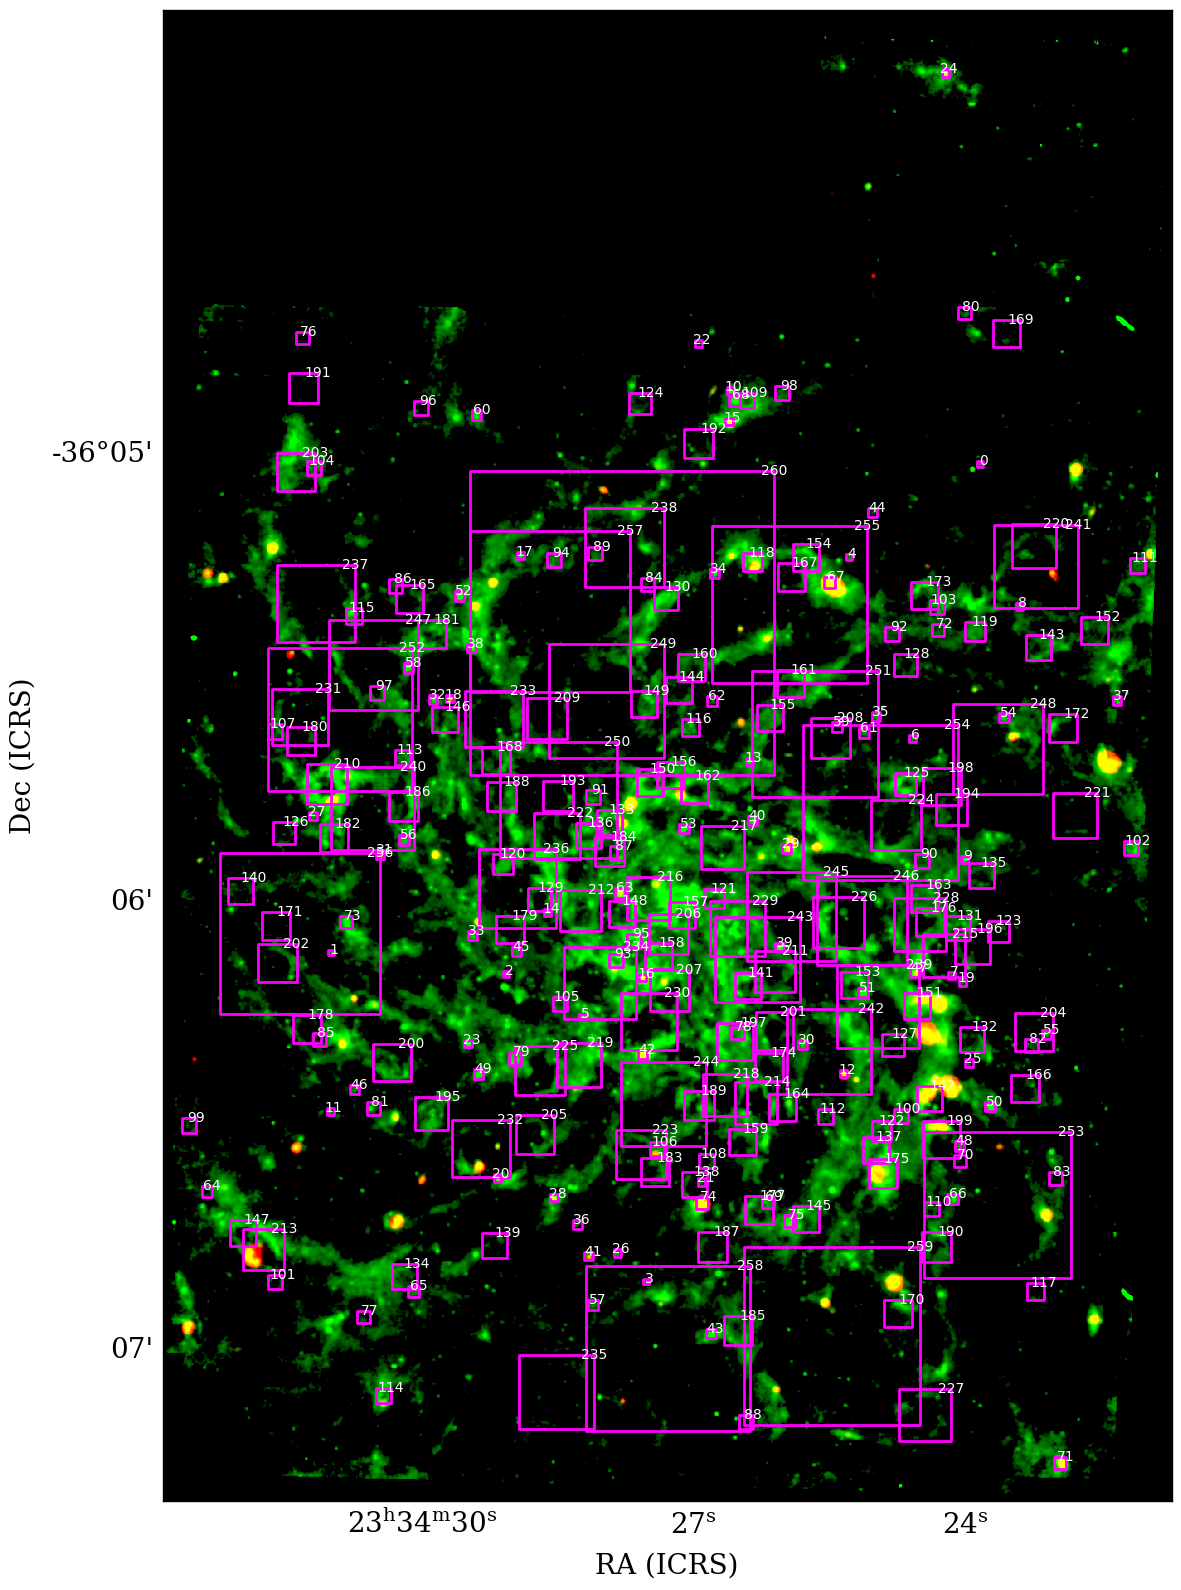

In [20]:
# --- 4.5. 全体図の作成 ---
rgb_image_path = glob.glob(os.path.join(RGB_FIG_PATH, f'*{galaxy_dic["galaxy_name"]}*smooth*'))[0]
output_map_path = os.path.join(concat_pic_dir, f'{galaxy_dic["galaxy_name"]}_predict.jpeg')
save_detection_map(fits_g_path, rgb_image_path, catalogue, wcs_header, output_map_path)

In [21]:
cutout_images_for_grid, raw_data = [], []
if os.path.exists(each_pic_dir):
    print('REMOVE FILES ...')
    shutil.rmtree(each_pic_dir)
    os.makedirs(each_pic_dir, exist_ok=True)

for _, row in catalogue.iterrows():
    # パディングを追加して切り出し範囲を決定
    height = row['height_pix']
    width = row['width_pix']
    y_min = int(row['y_pix_min'] - height/3)# * CUTOUT_PADDING_FACTOR)
    y_max = int(row['y_pix_max'] + height/3)# * CUTOUT_PADDING_FACTOR)
    x_min = int(row['x_pix_min'] - width/3)# * CUTOUT_PADDING_FACTOR)
    x_max = int(row['x_pix_max'] + width/3)# * CUTOUT_PADDING_FACTOR)
    
    # 画像を切り出し
    cutout_data = image_data[y_min:y_max, x_min:x_max, :].copy()
    if cutout_data.shape[0] * cutout_data.shape[1] == 0:
        pass
    else:
        raw_data.append(cutout_data)

        dim_data = []
        for dim in range(cutout_data.shape[2]):
            d = median_filter(cutout_data[:,:,dim], size=3)
            dim_data.append(d[:,:,None])

        cutout_data = np.concatenate(dim_data, axis=2)
        cutout_data[:,:,0] = 0
        display_img = normalize_rp(cutout_data, 0.11, 0.11)
        
        # --- 個別画像の保存 ---
        fig = plt.figure()
        ax = fig.add_subplot(projection=w)
        ax.imshow(display_img)
    
        # ★★★ 重要: この距離は銀河ごとに変更する必要があります ★★★    
        # add_scalebar(ax, unified_scalebar_angle, label=f"{unified_scalebar_angle} pc", color="white", size_vertical=0.7)
        r_shape_y = display_img.shape[0]
        r_shape_x = display_img.shape[1]
        ax.text(int(r_shape_y/10*0.75), int(r_shape_y*7.5/10), f"{int(row['id'])}", size=70, color="w")
        ax.axis("off")
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
        output_each_path = os.path.join(each_pic_dir, f'NewDetect_{row["id"]}.png')
        fig.savefig(output_each_path, bbox_inches="tight", pad_inches=0)
        plt.close(fig)

        img_with_scalebar = cv2.imread(output_each_path)
        img_with_scalebar = cv2.cvtColor(img_with_scalebar, cv2.COLOR_BGR2RGB)
        img_with_scalebar = np.array(img_with_scalebar)
        sig1 = 1 / (2 * (np.log(2)) ** (1 / 2))
        display_img = normalize(img_with_scalebar.astype('float64'))
        resized_img = resize(display_img, 500)
        cutout_images_for_grid.append(resized_img[None])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


REMOVE FILES ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

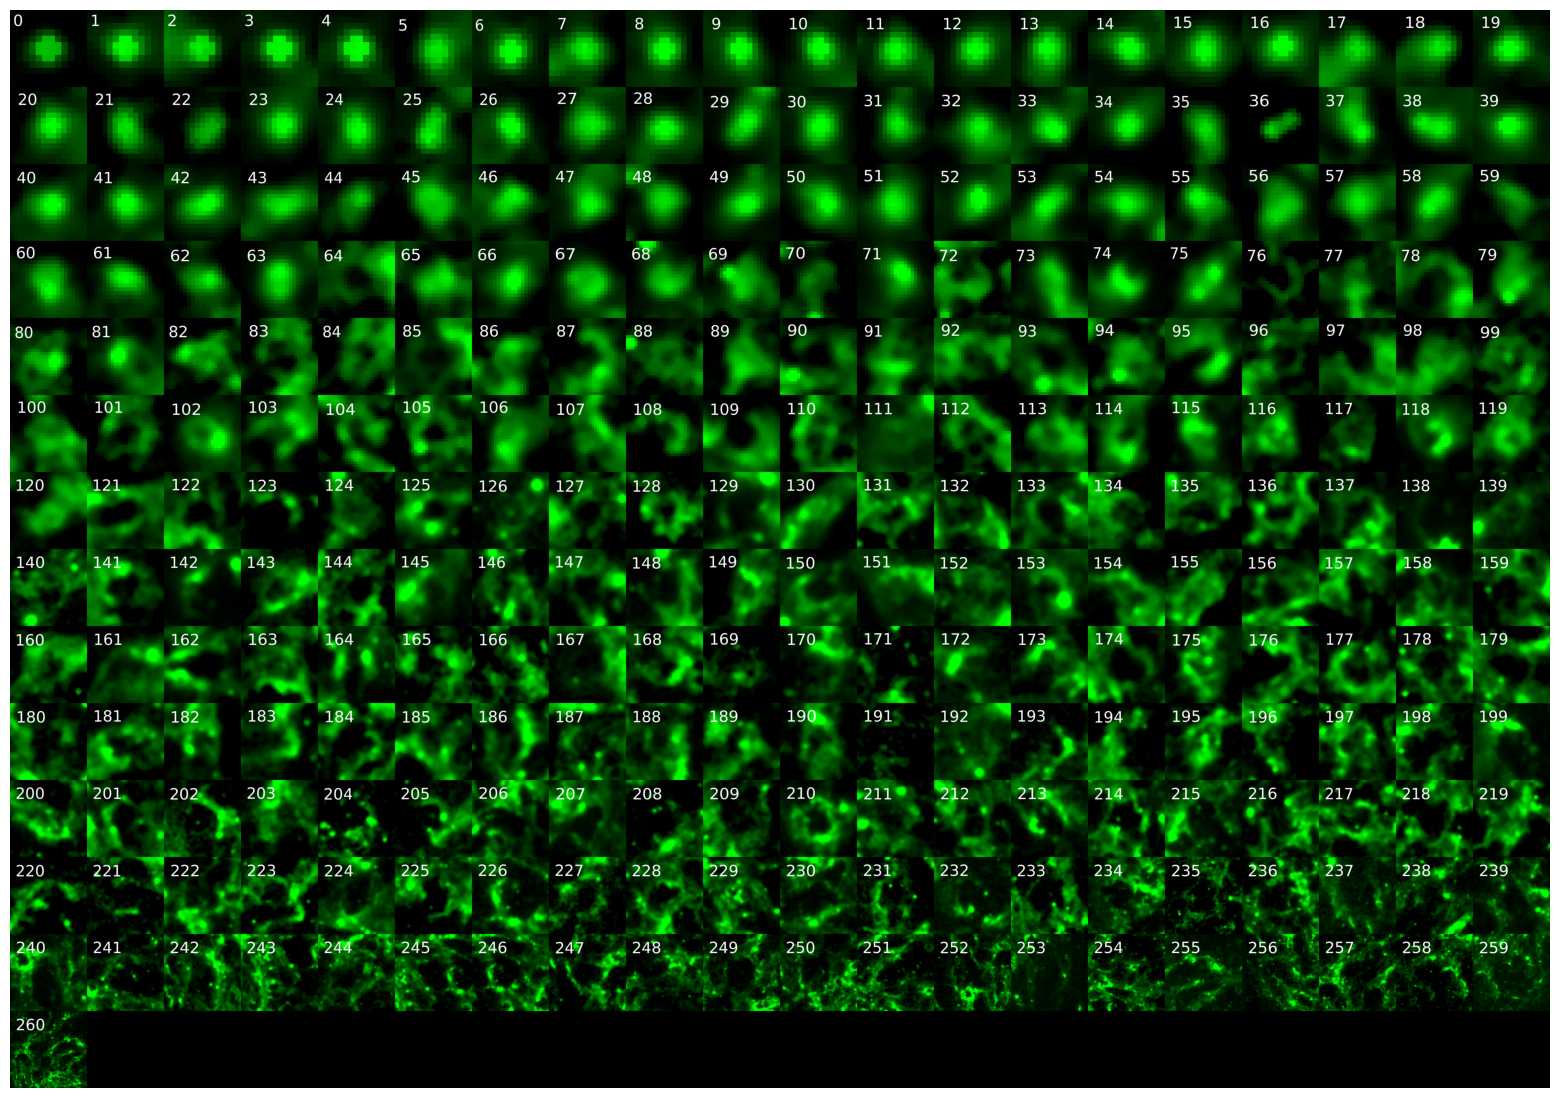

In [22]:
sort_data_ = torch.permute(torch.Tensor(np.concatenate(cutout_images_for_grid)), (0, 3, 1, 2))
grid_image = torchvision.utils.make_grid(sort_data_, padding=0, nrow=20).permute(1, 2, 0)

plt.figure(figsize=(20, 20 * grid_image.shape[0] / grid_image.shape[1]))
plt.imshow(grid_image)
plt.axis("off")

output_grid_path = os.path.join(concat_pic_dir, f'NewDetect_all_SuperBubble_{galaxy_dic["galaxy_name"]}.jpeg')
plt.savefig(output_grid_path, bbox_inches="tight", dpi=300, pad_inches=0.05)